# Feature Engineering / Selection

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor

from sklearn.feature_selection import mutual_info_regression # MI score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

rsv = 30 # random state variable to get reproduceable results

In [2]:
# load the dataset
data = pd.read_csv("dataset_versions/dataset_no_missing_values.csv")
sale_price = data.pop('SalePrice')

X_train_enc = pd.read_csv("/work/dataset_versions/encoded_dataset/X_train_enc.csv")
X_test_enc = pd.read_csv("/work/dataset_versions/encoded_dataset/X_test_enc.csv")

y_train_enc = pd.read_csv("/work/dataset_versions/encoded_dataset/y_train_enc.csv")
y_test_enc = pd.read_csv("/work/dataset_versions/encoded_dataset/y_test_enc.csv")

le_df = pd.read_csv("/work/dataset_versions/label_encoded_data.csv")

data7 = pd.read_csv("/work/dataset_versions/dataset7.csv")
X_train7, X_test7, y_train7, y_test7 = train_test_split(data7.drop('SalePrice', axis=1), data7.SalePrice, test_size=0.20, random_state=rsv)

In [3]:
# Instantiate a model object with given arguments
model = RandomForestRegressor(
    random_state=rsv,
    max_depth=14,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=1600,
    bootstrap=False,
)

In [4]:
# Function to evalutate how a dataset performs

def score_dataset(X, y, model=model):
    # Label encoding for categoricals
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
        
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(model, X, log_y, cv=5, scoring="neg_mean_squared_error")
    score = -1 * score.mean()
    score = np.sqrt(score)

    # Calculate Root mean squared error
    rmse = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error")
    rmse = -1 * rmse.mean()
    rmse = np.sqrt(rmse)
    print(f"root mean squared error: {rmse}")

    f = open("record.txt", "r")
    record = f.read()
    if score==float(record):
        print(f'Same as record.')
    elif score<float(record):
        print(f'NEW RECORD!\n')
        with open("record.txt", 'w') as f:
            print(score,file=f)

    print("The root mean squared log error is:")
    return round(score,6)

In [5]:
# The score_dataset function
score_dataset(X_train7, y_train7)

root mean squared error: 22903.555806540026
Same as record.
The root mean squared log error is:


0.12311

In [6]:
# Fit the model to the training data
model.fit(X_train7, y_train7)

RandomForestRegressor(bootstrap=False, max_depth=14, max_features='sqrt',
                      n_estimators=1600, random_state=30)

In [7]:
importance_dict = {}
for name, score in zip(X_train7.columns, model.feature_importances_):
    importance_dict[name] = score

marklist=sorted((value, key) for (key,value) in importance_dict.items())
sortdict=dict([(k,v) for v,k in marklist])
sortdict

{'Heating': 0.00014877412216784226,
 'BsmtHalfBath': 0.0002116098293166848,
 'LowQualFinSF': 0.00027969815922877073,
 'Electrical': 0.00031101732629188665,
 'Alley': 0.0003302798352752806,
 'RoofMatl': 0.00043889381613994413,
 'Fence': 0.000531202154299802,
 'ExterCond': 0.0005489358316627601,
 'KitchenAbvGr': 0.0005865101357120665,
 'PavedDrive': 0.0006019001721408883,
 'BsmtFinType2': 0.0007174715310772059,
 'LandContour': 0.0007491091934475559,
 'BsmtCond': 0.0007744023821107826,
 'Condition1': 0.0008013357027505163,
 'BldgType': 0.0008921122585279611,
 'Functional': 0.0009088683208009005,
 'LotConfig': 0.0009096055017627988,
 'EnclosedPorch': 0.0009255692368415012,
 'SaleType': 0.0010854306604742194,
 'GarageCond': 0.0013511781353455997,
 'LotShape': 0.0014981616063819091,
 'ScreenPorch': 0.0015276822014472125,
 'CentralAir': 0.0016394675341130866,
 'HouseStyle': 0.0019231888077871837,
 'GarageQual': 0.002007435555701377,
 'MasVnrType': 0.0020345215760594493,
 'BsmtFullBath': 0.002

In [8]:
# Pickle our RandomRegressor model as a pickle file.
#import pickle
#with open("rfr_model2.pickle", "wb") as pickle_out:
#    pickle.dump(fmodel, pickle_out)

In [9]:
#test = pd.read_csv('/work/ames_housing_dataset/test.csv')

#predicted_prices = fmodel.predict(test.columns)
#print(predicted_prices)

## MI-score

use mutual information to compute a utility score for a feature, giving you an indication of how much potential the feature has.

In [10]:
# a function to compute the Mutual information scores
# A thanks to Ryan Holbrook and Alexis Cook for providing this code snippet in the following link:
# https://www.kaggle.com/code/ryanholbrook/mutual-information

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores_sns(scores):
    scores = scores.sort_values(ascending=True)
    #sns.barplot(, missing_values_pct)
    #plt.title("Mutual Information Scores")

# a functions to plot the mutual information scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.grid()
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

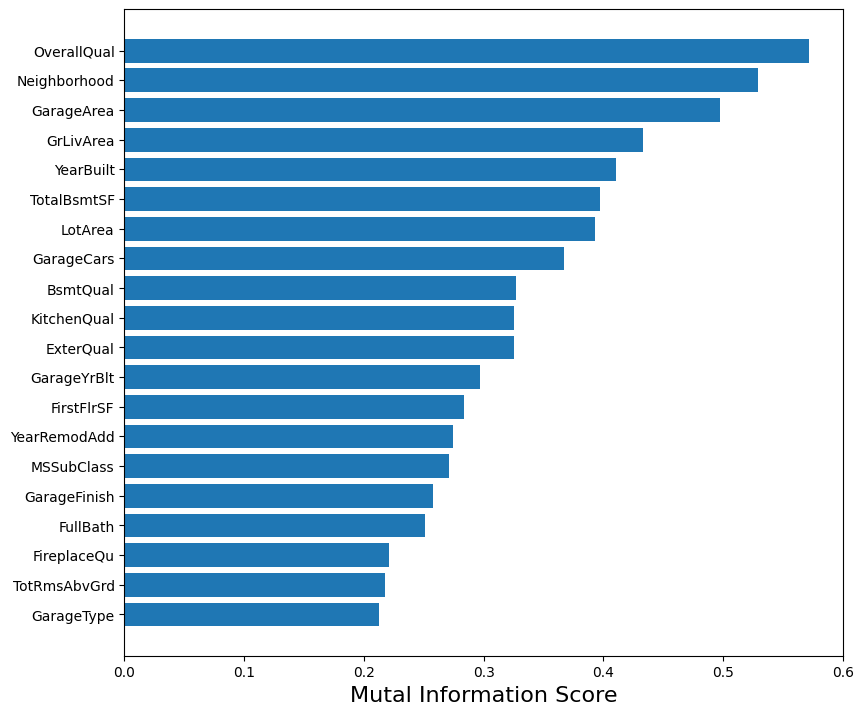

In [12]:
mi_scores = make_mi_scores(data, sale_price)
plt.figure(dpi=100, figsize=(8, 7))
jg = mi_scores.head(20)
scores = jg.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)
plt.tight_layout()
plt.yticks(width, ticks)
plt.xlabel("Mutal Information Score", fontsize=16)

plt.savefig(fname="graphs/mi_scores_updated", transparent=True) 

# EDA

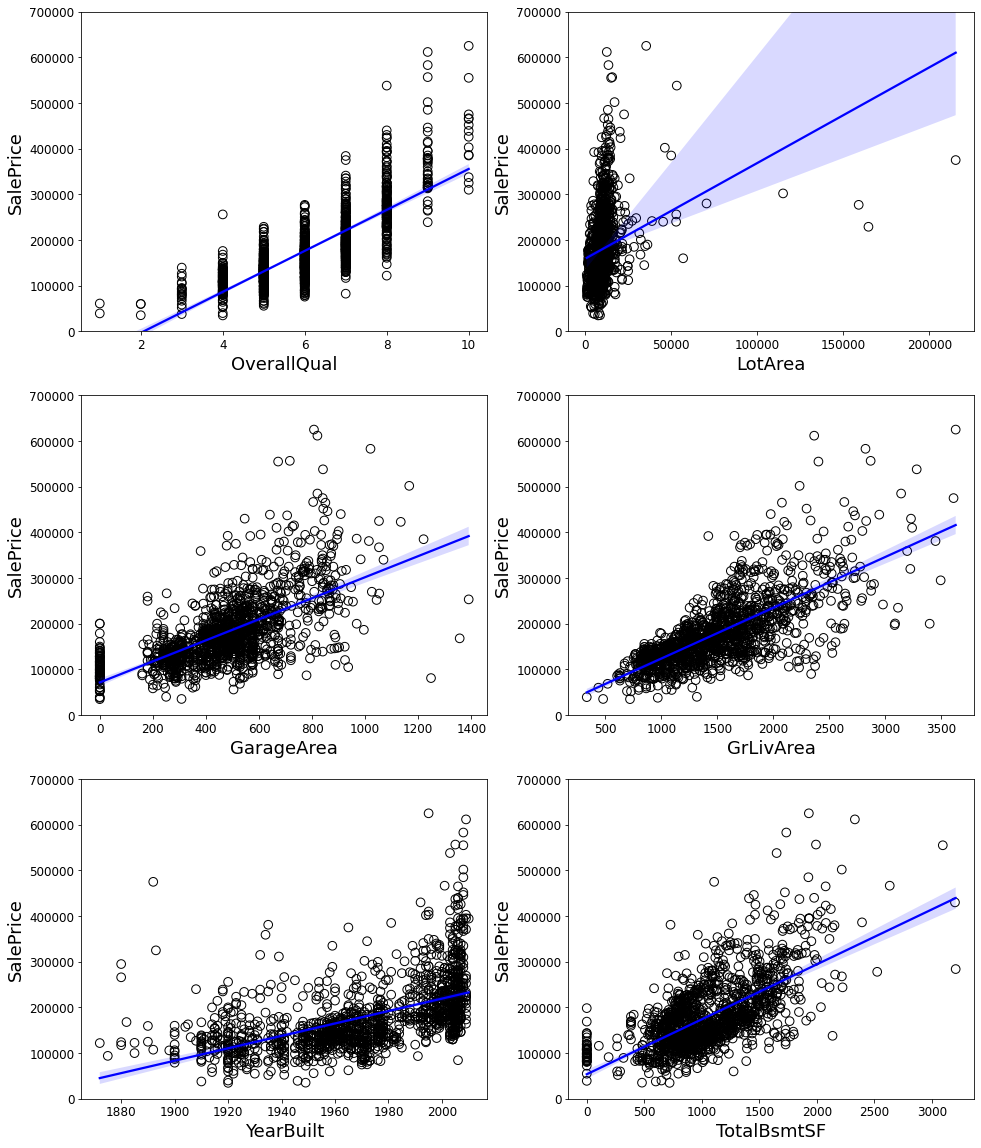

In [13]:
plt.figure(figsize=(16, 20))

for i in range(6):
    if mi_scores.index[i] == 'Neighborhood':
        feature = mi_scores.index[6]
    else:
        feature = mi_scores.index[i]
    plt.subplot(3,2,i+1)
    plt.scatter(le_df[feature], le_df['SalePrice'], facecolors='none', edgecolors='k', s=75)
    sns.regplot(x=feature, y='SalePrice', data=le_df, scatter=False, color='b')
    ax=plt.gca()
    ax.set_ylim([0,700000])
    plt.xlabel(feature, fontsize=18)
    plt.xticks(fontsize=12)
    plt.ylabel('SalePrice', fontsize=18)
    plt.yticks(fontsize=12)
    plt.savefig(fname="graphs/saleprice_vs_top_six_features", transparent=True) # saves the figure to the file explore


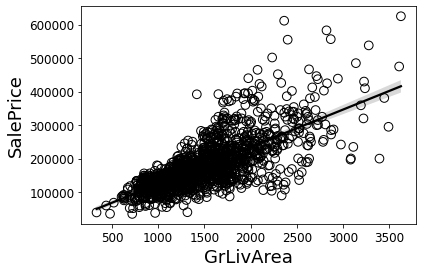

In [14]:
feature = mi_scores.index[3]
plt.scatter(data[feature], sale_price, facecolors='none', edgecolors='k', s=75)
sns.regplot(x=feature, y=sale_price, data=data, scatter=False, color='k')
ax=plt.gca()
#ax.set_ylim([0,800000])
plt.xlabel(feature, fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice', fontsize=18)
plt.yticks(fontsize=12)
plt.savefig(fname="graphs/grlivarea_outliers", transparent=True) # saves the figure to the file explore

As we observe above, the variable "OverallQual" has the higher MI-score, indicating it has the strongest relationship with the sales price of a house. Below is a stripplot where we also observe an rather strong opwards going tendency.

## Correlation mapping

In [15]:
corr = data.corr(method="pearson") # calculates the corralation between numerical features

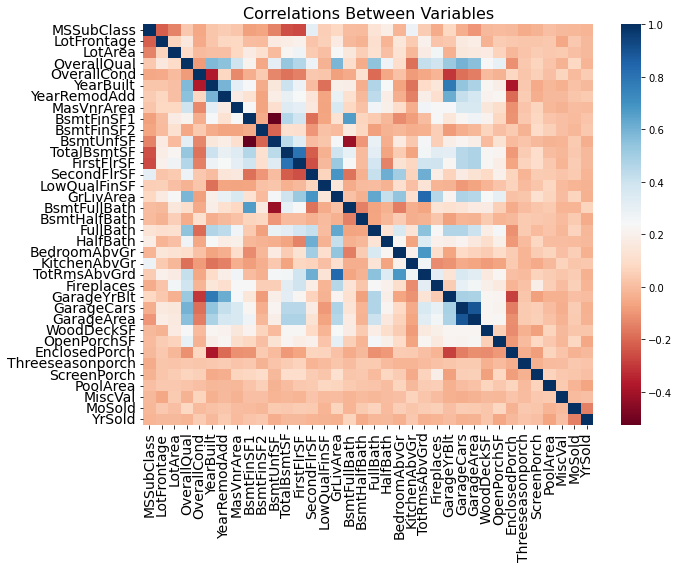

In [16]:
# Visualise the correlations between numerical variables using Pearson Correlation Method
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="RdBu")
plt.title("Correlations Between Variables", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(fname="graphs/correlation_mapping", transparent=True) 

## Removing quasi-constant features

Quasi-constant features are those that show the same value for the great majority of the observations of the dataset. In general, these features provide little if any information that allows a machine learning model to discriminate or predict a target. But there can be exceptions. So we should be careful when removing these type of features. Identifying and removing quasi-constant features, is an easy first step towards feature selection and more easily interpretable machine learning models.

Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.

In [17]:
# To identify quasi-constant features, we can use the VarianceThreshold function from sklearn.

from sklearn.feature_selection import VarianceThreshold
numeric_data = data.select_dtypes(include=['int64', 'float64'])

sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
sel.fit(numeric_data)  # fit finds the features with low variance

# get_support is a boolean vector that indicates which features 
# are retained. If we sum over get_support, we get the number
# of features that are not quasi-constant
print(f"There are {sum(sel.get_support())} non quasi-constant features with a VarianceThreshold of 0.01") 

There are 36 non quasi-constant features with a VarianceThreshold of 0.01


This means that we have no quasi-constant features in the dataset (for numeric values only)

In [18]:
# This prints the quasi-constant features
#print(
    #len([
      #  x for x in df.columns
     #   if x not in df.columns[sel.get_support()]
    #]))

#[x for x in df.columns if x not in df.columns[sel.get_support()]]

## Removing bad features

In [19]:
X_train_le, y_train_le, X_test_le, y_test_le = train_test_split(le_df, le_df.SalePrice, test_size=0.20, random_state=30)

In [20]:
best67_df = X_train_le[mi_scores[mi_scores > 0.005].index]
#best67_df['SalePrice'] = y_train_le

worst12_df = X_train_le[mi_scores[mi_scores < 0.005].index]



## Using grid search and random search to finetune hyperparameters

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def rfr_grid_search():
    # Define hyperparameter tuning grid
    grid = { 
        'n_estimators': [50,100,150,200,250,300,350,400],
        'max_features': ['sqrt','log2','auto'],
        'max_depth' : [5,6,7,8,9,10],
        'min_samples_split' : [2,10,20,30],
        'min_samples_leaf' : [1,3,5,7,9],
        'random_state' : [rsv]
    }

    # instanciates grid search object with arguments
    gs_rfr = GridSearchCV(estimator=rfr, param_grid=grid, cv=5) 
    # perform grid search
    gs_result = gs_rfr.fit(X_train_le, y_train_le) 

    # print the best hyperparameter configurations
    return gs_result.best_params_ 

## Creating synthetic features

We create a function to test out different synthetic features:

We are here investigating if certain synthetic features we can create, are improving the model

In [22]:
# Pass a df (including target value) and get back the target value and the synthetic features added
def create_features(df):
    X = df.copy()
    y = X.pop("SalePrice")

    # Features that improve by them selves
    X['OverallQuCondRatio'] = df.OverallQual * df.OverallCond # because the two features scored high, so we are trying to combine them
    X['LotAreaGrLivAreaProduct'] = round(X.LotArea * X.GrLivArea / 1000000, 2)
    X['YearRemodAddYearBuiltProduct'] = round(X.YearRemodAdd * X.YearBuilt / 1000000 ,2)
    X['KitchenQualFullBathProduct'] = X.KitchenQual * X.FullBath # very good
    X['OverallQualGrLivAreaProduct'] = round(X.OverallQual * X.GrLivArea / 1000, 2) # very good

    #X['FirstFlrF'] = round(np.sqrt(df.FirstFlrSF),2)

    ### Features that dont improve the model' ### 

    #X['test'] = X.GarageFinish * X.GarageType
    #X['test'] = df.GarageArea - df.GrLivArea
    #X['SecondFlrF'] = np.sqrt(df.SecondFlrSF)
    #X["LivLotRatio"] = df.GrLivArea / df.LotArea
    #X['GrLivAreaDistFromMedian'] = df.GrLivArea - np.median(df.GrLivArea)
    #X["Spaciousness"] = round((df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd)
    #X["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch
    return X, y

In [23]:
data7_sale_price = data7.pop('SalePrice')

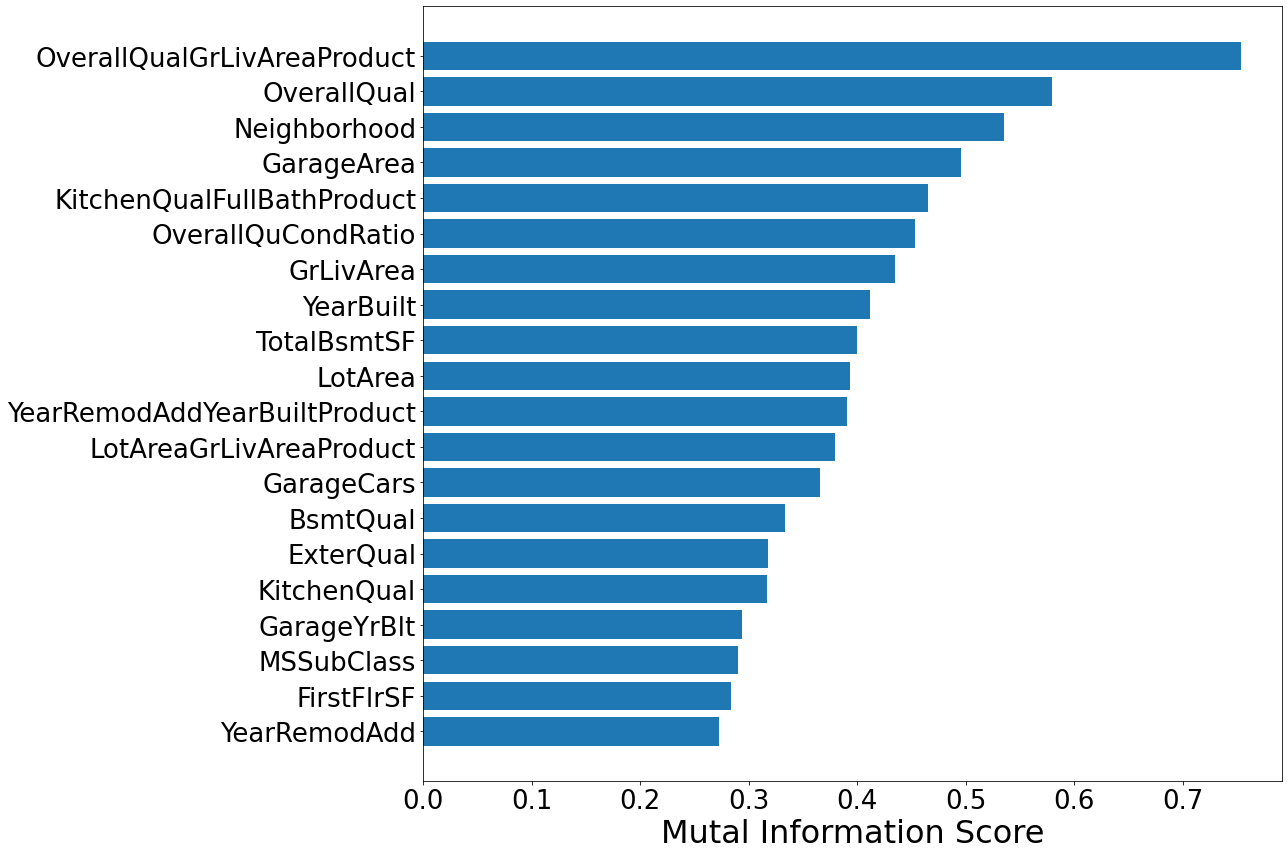

In [24]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

mi_scores = make_mi_scores(data7, sale_price)
plt.figure(figsize=(18, 12))
jg = mi_scores.head(20)
scores = jg.sort_values(ascending=True)
width = np.arange(len(scores))
ticks = list(scores.index)
plt.barh(width, scores)

plt.yticks(width, ticks, fontsize=26)
plt.xticks(fontsize=26)
plt.xlabel("Mutal Information Score", fontsize=32)
#plt.subplots_adjust(left=0.30)

plt.savefig(fname="graphs/mi_scores_updated", transparent=True) 

In [26]:
# used to make the test predictions for kaggle
test = pd.read_csv("/work/dataset_versions/kaggle_test.csv")

test_id = test['Id']

test = test[best67_df.columns]

test = create_features(test)
test.to_csv(path_or_buf="dataset_versions/kaggle_test_f.csv", index=False) 

kaggle_pred = fmodel.predict(test)

KeyError: 'SalePrice'

In [ ]:
my_submission = pd.DataFrame({'Id': test_id, 'SalePrice': kaggle_pred})
my_submission.to_csv('submission.csv', index=False)

In [ ]:
#X, y = create_features(le_df[best67_df.columns]) # create the unsplit dataset - for saving the df
X, y = create_features(best67_df) # creates the split dataset - for testing the MI-score

score_dataset(X,y)

root mean squared error: 22903.555806540026
Same as record.
The root mean squared log error is:


0.12311

In [ ]:
dataset7 = X.join(y)
#dataset7.to_csv(path_or_buf="dataset_versions/dataset6.csv", index=False) 

### Feature Importance from https://medium.com/@sdhnshu/feature-engineering-with-random-forests-part2-160eb0356172 idk måske slet

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, 
                          max_features=0.5, n_jobs=-1, 
                          oob_score=True)
m.fit(X_train_enc, y_train_enc)
# rf_feat_importance wrapper from Fast.ai
fi = rf_feat_importance(m, X_train_enc)
#fi[:10].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
fi[:10]

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


,cols,imp
191,OverallQual,0.314941
203,GrLivArea,0.138758
165,ExterQual,0.092818
213,GarageCars,0.071670
214,GarageArea,0.039684
199,TotalBsmtSF,0.035059
167,BsmtQual,0.033726
196,BsmtFinSF1,0.033211
170,KitchenQual,0.032678
200,FirstFlrSF,0.027356


In [ ]:
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

In [ ]:
to_keep = fi[fi.imp>0.005].cols

df_keep = X_train_enc[to_keep].copy()
#X_train_enc, X_test_enc = split_vals(df_keep, X_test_enc)
#m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
#                       max_features=0.5, n_jobs=-1, oob_score=True)
#m.fit(X_train, y_train)
#print_score(m)
#fi = rf_feat_importance(m, df_keep)
#plot_fi(fi[:30]);

In [ ]:
from sklearn import metrics

x1 = [60,80,100,120]
y1 = [67,78,99,112]

x2 = [60,80,100,120,700]
y2 = [67,78,99,112,102]

x3 = [100]
y3 = [90]

print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(x1, y1)),2))
print('Root Mean Squared Log Error:', round(metrics.mean_squared_log_error(x1,y1,squared=False),3))

print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(x2, y2)),2))
print('Root Mean Squared Log Error:', round(metrics.mean_squared_log_error(x2,y2,squared=False),3))

print('RMSE:', np.sqrt(metrics.mean_squared_error(x3, y3)))
print('RMSLE:', metrics.mean_squared_log_error(x3,y3,squared=False))

Root Mean Squared Error: 5.43
Root Mean Squared Log Error: 0.066
Root Mean Squared Error: 267.48
Root Mean Squared Log Error: 0.86
RMSE: 10.0
RMSLE: 0.10426101032440993


In [ ]:
g = sns.lmplot(x="GrLivArea", y="SalePrice", markers=" ", hue="OverallQual", data=data7)

g.set(ylim=(0,600000))
g.set_xlabels("GrLiveArea", fontsize=14)
g.set_ylabels("SalePrice", fontsize=14)

g.savefig(fname="/work/graphs/sale_overallqual_GrLiv", transparent=True)

KeyError: "['SalePrice'] not in index"

In [ ]:
data7.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     14
2       3
1       2
Name: OverallQual, dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a79dfa2f-1b6b-4b40-b0ca-7dec9e2a123f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>